#Machine Prep

In [1]:
%%bash
apt install graphviz libgraphviz-dev

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2

In [2]:
%%bash
pip -q install networkx pygraphviz powerlaw pandas > /dev/null 2>&1 || true

In [10]:
import networkx as nx, matplotlib.pyplot as plt, pandas as pd, numpy as np, random, powerlaw
from collections import defaultdict
%matplotlib inline

#Pedigree Helpers

In [8]:
def ped_to_graph(ped_path):
    cols = ['fam','id','dad','mom','sex','phen']
    # read everything as string to avoid implicit ints
    df = pd.read_csv(ped_path, sep=r'\s+', header=None, names=cols, dtype=str)

    G = nx.DiGraph()
    for _, r in df.iterrows():
        G.add_node(
            r['id'],
            family=r['fam'],
            sex=int(r['sex']),
            phenotype=int(r['phen'])
        )
    for _, r in df.iterrows():
        if r['dad'] != '0':
            G.add_edge(r['dad'], r['id'])
        if r['mom'] != '0':
            G.add_edge(r['mom'], r['id'])
    return G


def graphviz_pos(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog='dot')
    except Exception:
        return nx.spring_layout(G, seed=42)

def plot_pedigree(G, title="Pedigree"):
    pos = graphviz_pos(G)
    colors = ['red' if G.nodes[n].get('phenotype',0)==2 else 'lightblue' for n in G]
    nx.draw(G, pos, node_color=colors, with_labels=True, arrows=True)
    plt.title(title)
    plt.show()

# ---------------- pedigree helper utilities -----------------
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share â‰¥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs
def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl
# ------------------------------------------------------------

#Pedigree Simulation

In [5]:
ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''
open('ad_complete.ped','w').write(ped_AD)

ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

156

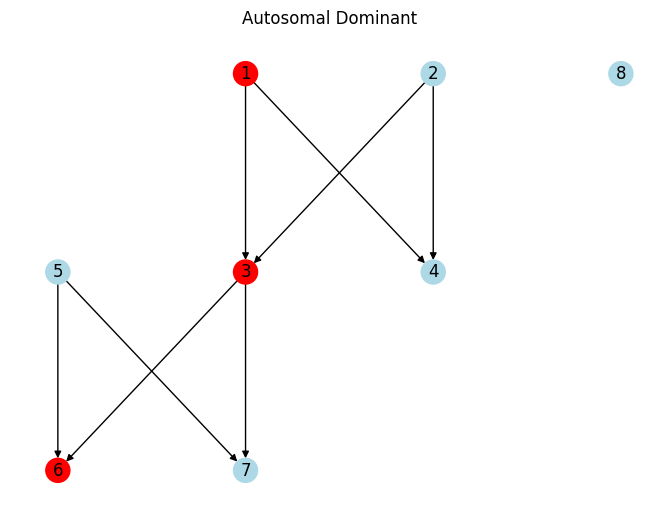

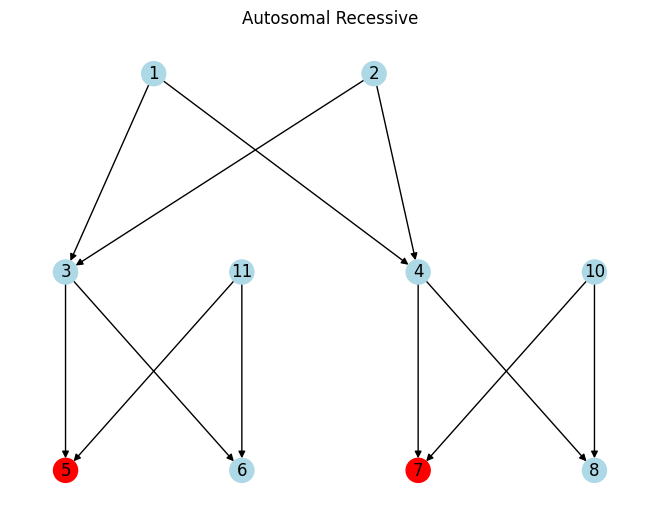

In [6]:
G_ad = ped_to_graph('ad_complete.ped')
G_ar = ped_to_graph('ar_complete.ped')
plot_pedigree(G_ad, 'Autosomal Dominant')
plot_pedigree(G_ar, 'Autosomal Recessive')

#Pedigree Classification

In [17]:
def pedigree_features(G):

    phen = nx.get_node_attributes(G,'phenotype')
    aff_nodes = [n for n,p in phen.items() if p==2]
    unaff_nodes = [n for n,p in phen.items() if p!=2]

    # ratio affected with affected parent
    aff_aff_parent = 0
    for n in aff_nodes:
        if any(phen.get(p,0)==2 for p in parents(G,n)):
            aff_aff_parent +=1
    ratio_aff_parent = aff_aff_parent/len(aff_nodes) if aff_nodes else 0

    # generation coverage
    gen = generations(G)
    gens_aff = {gen[n] for n in aff_nodes}
    gen_cov = len(gens_aff)/(max(gen.values())+1) if gen else 0

    # sibling clustering
    sib_pairs=0; aa_pairs=0
    for n in aff_nodes:
        for sib in siblings(G,n):
            if sib in aff_nodes:
                aa_pairs+=1
            sib_pairs+=1
    sibling_aff_ratio = aa_pairs/sib_pairs if sib_pairs else 0

    # betweenness carriers
    bet = nx.betweenness_centrality(G)
    carrier = [n for n in unaff_nodes if G.nodes[n].get('phenotype')!=2 and G.nodes[n].get('genotype') != 0]
    avg_bet_carrier = np.mean([bet[n] for n in carrier]) if carrier else 0
    avg_bet_unaff = np.mean([bet[n] for n in unaff_nodes]) if unaff_nodes else 0

    #new betweeness of carriers (with graph of only affected and carriers)
    new_bet = nx.betweenness_centrality(G.subgraph(aff_nodes+carrier))
    new_avg_bet_carrier = np.mean([new_bet[n] for n in carrier]) if carrier else 0


    return dict(ratio_aff_parent=ratio_aff_parent, gen_cov=gen_cov, sibling_aff_ratio=sibling_aff_ratio, avg_bet_carrier=avg_bet_carrier, avg_bet_unaff=avg_bet_unaff, new_avg_bet_carrier=new_avg_bet_carrier)

def classify_inheritance_simple(G):
    feats = pedigree_features(G)
    if feats['ratio_aff_parent']>=(7/12) or feats['sibling_aff_ratio']>=(7.625/12):
        return 'AD',feats
    elif feats['ratio_aff_parent']<=(2.5/12) or feats['sibling_aff_ratio']<=(2.625/12):
        return 'AR',feats
    else:
        return 'Uncertain',feats

mode_ad, feats_ad = classify_inheritance_simple(G_ad)
mode_ar, feats_ar = classify_inheritance_simple(G_ar)
print('Predicted mode AD pedigree:', mode_ad, feats_ad)
print('Predicted mode AR pedigree:', mode_ar, feats_ar)


Predicted mode AD pedigree: AD {'ratio_aff_parent': 0.6666666666666666, 'gen_cov': 1.0, 'sibling_aff_ratio': 0.0, 'avg_bet_carrier': np.float64(0.0), 'avg_bet_unaff': np.float64(0.0), 'new_avg_bet_carrier': np.float64(0.0)}
Predicted mode AR pedigree: AR {'ratio_aff_parent': 0.0, 'gen_cov': 0.5, 'sibling_aff_ratio': 0.0, 'avg_bet_carrier': np.float64(0.013888888888888888), 'avg_bet_unaff': np.float64(0.013888888888888888), 'new_avg_bet_carrier': np.float64(0.013888888888888888)}
